# NetColoc analysis of rare variants in Autism spectrum disorder (ASD) and Congenital Heart Disease (CHD)

Example of NetColoc workflow on genes associated with rare exome variants in ASD and CHD

**Some background:**

Here we introduce NetColoc, a tool which evaluates the extent to which two gene sets are related in network space, i.e. the extent to which they are colocalized in a molecular interaction network, and interrogates the underlying biological pathways and processes using multiscale community detection. This framework may be applied to any number of scenarios in which gene sets have been associated with a phenotype or condition, including rare and common variants within the same disease, genes associated with two comorbid diseases, genetically correlated GWAS phenotypes, GWAS across two different species, or gene expression changes after treatment with two different drugs, to name a few. NetColoc relies on a dual network propagation approach to identify the region of network space which is significantly proximal to both input gene sets, and as such is highly effective for small to medium input gene sets.



# _Obtain input gene sets and interactome_

### 1. Load required packages

In [91]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime

import sys

# % matplotlib inline

In [2]:

# verify DDOT was installed
import ddot

from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
from netcoloc import validation


### 2. Load two gene sets of interest


Identify two gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. 

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [3]:
# set names of geneset 1 and geneset 2
# ------ customize this section based on your gene sets and how they should be labeled -------
d1_name='ASD'
d2_name='CHD'

In [4]:

# ------ customize this section based your input genesets -------

# load rare variants Satterstrom et al 2020; PMID: 31981491

D1_df = pd.read_csv('data/Satterstrom--Top-102-ASD-genes--May2019.csv')
D1_df.index = D1_df['gene']
print('number '+d1_name+' genes:')
print(len(D1_df))
D1_genes = D1_df.index.tolist() # define rare variant genes to seed network propagation
print(D1_genes[0:5])

number ASD genes:
102
['CHD8', 'SCN2A', 'SYNGAP1', 'ADNP', 'FOXP1']


In [5]:
# ------ customize this section based your input genesets -------

# load D2 rare variant genes from Jin et al 2017; PMID: 28991257
D2_df = pd.read_csv('data/CHD_HC.tsv',sep='\t')

D2_genes = D2_df['0'].tolist()
print('number '+d2_name+' genes:')
print(len(D2_genes))
print(D2_genes[0:5])

number CHD genes:
66
['KMT2D', 'CHD7', 'PTPN11', 'NSD1', 'NOTCH1']


In [6]:
# how much overlap between gene sets?
print('number of '+d1_name+' and '+d2_name+' genes overlapping:')
print(len(np.intersect1d(D1_genes,D2_genes)))

number of ASD and CHD genes overlapping:
6


### 3. Select molecular interaction network to use for the analysis. 

Identify network UUID on  Ndex (Pratt et al. 2015) and use this to import to jupyter notebook using. 

**Usage note**: PCnet is a general purpose interactome, a good starting place https://www.sciencedirect.com/science/article/pii/S2405471218300954. Use STRING for machines with lower memory.

In [7]:

interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# pcnet appears to have some self edges... should remove them. 
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

number of nodes:
17185

number of edges:
420534


In [8]:
int_nodes = list(G_int.nodes)

# _Identify network colocalized gene network_

### 4. Precalculate matrices needed for propagation. This step should take a few minutes 

Network propagation from genes on selected interactome
- Control for degree of input genes
- Generate a proximity z-score, which defines genes which are closer to input set than expected by chance.
- Repeat for rare and common variant genes, defined above

Background on network propagation: https://www.nature.com/articles/nrg.2017.38.pdf?origin=ppub


In [9]:
# pre calculate mats used for netprop... this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)


calculating w_prime

calculating w_double_prime


### 5. Subset seed genes to those found in the selected interactome.

In [10]:
# subset seed genes to those found in interactome
print(len(D1_genes))
D1_genes = list(np.intersect1d(D1_genes,int_nodes))
print(len(D1_genes))

print(len(D2_genes))
D2_genes = list(np.intersect1d(D2_genes,int_nodes))
print(len(D2_genes))


102
98
66
65


### 6. Run network propagation from both seed gene sets independently.

In [11]:
# D1 netprop
print('\nCalculating D1 variant z-scores: ')
z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D1_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D1 = pd.DataFrame({'z':z_D1})

z_D1.sort_values('z',ascending=False).head()


Calculating D1 variant z-scores: 


,z
KDM6B,10.991122
ASXL3,10.905475
TRAF7,10.895410
KMT2E,10.783263
DIP2A,10.639522


In [12]:
# D2 variant netprop
print('\nCalculating D2 variant z-scores: ')
z_D2, Fnew_D2, Fnew_rand_D2 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D2_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D2 = pd.DataFrame({'z':z_D2})
z_D2.sort_values('z',ascending=False).head()


Calculating D2 variant z-scores: 


,z
CLUH,13.015273
ZEB2,10.239921
NR6A1,9.672462
CHD7,9.607006
SAMD11,9.116133


### 7. Compute the network colocalization enrichment for gene set pair. If gene sets are significantly colocalized, proceed with analysis. 


Size of network co-localization subgraph compared to null model created by permuting individual propagation z-scores. 


In [13]:


seed_dict = {d1_name:D1_genes,d2_name:D2_genes}
# --------------------------------------------------------------------------------------------

zthresh=3

z_d1d2_size, high_z_rand = network_colocalization.calculate_expected_overlap(
    z_D1['z'],
    z_D2['z'],
    plot=False,
    num_reps=100,
    z_score_threshold=zthresh,
    z1_threshold=1.5,
    z2_threshold=1.5
)

ztemp = (z_d1d2_size - np.mean(high_z_rand)) / np.std(high_z_rand)
ptemp = norm.sf(ztemp)
print(d1_name + ' + ' + d2_name)
print('size of network intersection = ' + str(z_d1d2_size))
obs_exp_temp = float(z_d1d2_size) / np.mean(high_z_rand)
print('observed size/ expected size = ' + str(obs_exp_temp))
print('p = ' + str(ptemp))

# save the num overlap and overlap p-val
network_num_overlap = z_d1d2_size
network_pval_overlap = ptemp
network_obs_exp = obs_exp_temp
network_exp_mean_overlap = np.mean(high_z_rand)
network_exp_std_overlap = np.std(high_z_rand)


ASD + CHD
size of network intersection = 350
observed size/ expected size = 2.1875
p = 1.97776641905858e-46


### 8. Plot the sizes of the observed and expected NetColoc subgraphs.

(-1, 2)

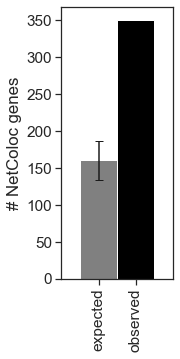

In [14]:
# plot the observed and expected overlaps
plt.figure(figsize=(2,5))
plt.bar([0,1],[network_exp_mean_overlap,network_num_overlap],color=['gray','black'],width=1)
plt.errorbar([0],[network_exp_mean_overlap],[2*network_exp_std_overlap],color='k',capsize=4)
plt.ylabel('# NetColoc genes')
plt.xticks([0,1],['expected','observed'],rotation='vertical')
plt.xlim([-1,2])




### 9. Compute network colocalization subgraph.

In [15]:
# select genes in network intersection, make a subgraph

G_overlap = network_colocalization.calculate_network_overlap_subgraph(G_int,z_D1['z'],z_D2['z'],z_score_threshold=zthresh,
                                                                     z1_threshold=1.5,z2_threshold=1.5)
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))

350
1810


### 10. Transform NetColoc subgraph edges to cosine similarities

Cosine similarity transformation (and network transformations in general) provide better visualization of clusters


In [16]:
G_cosSim=network_colocalization.transform_edges(G_overlap,method='cosine_sim',edge_weight_threshold=0.95)

computing the adjacency matrix...
computing the cosine similarity...


/Users/brinrosenthal/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


rank transforming...
number of transformed edges returned = 
1721


/Users/brinrosenthal/anaconda3/lib/python3.7/site-packages/netcoloc/network_colocalization.py:241: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sim_rank.values[[np.arange(sim_rank.shape[0])]*2] = 0


# _Compute network colocalized systems map_

### 11. Convert network colocalization subgraph to form used in community detection module

In [17]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_overlap.nodes))
node_df['d1_seeds']=0
node_df['d2_seeds']=0
node_df['d1_seeds'].loc[list(np.intersect1d(seed_dict[d1_name],node_df.index.tolist()))]=1
node_df['d2_seeds'].loc[list(np.intersect1d(seed_dict[d2_name],node_df.index.tolist()))]=1
node_df['z_d1']=z_D1.loc[list(G_overlap.nodes)]['z']
node_df['z_d2']=z_D2.loc[list(G_overlap.nodes)]['z']
node_df['z_both']=node_df['z_d1']*node_df['z_d2']
node_df['d1_name']=d1_name
node_df['d2_name']=d2_name
node_df['sum_seeds']=node_df['d1_seeds']+node_df['d2_seeds']

node_df = node_df.sort_values('z_both',ascending=False)
node_df.head(15)

,d1_seeds,d2_seeds,z_d1,z_d2,z_both,d1_name,d2_name,sum_seeds
KDM5B,1,1,8.745623,8.198657,71.702356,ASD,CHD,2
CLUH,0,1,5.294906,13.015273,68.914648,ASD,CHD,1
KMT2C,1,1,8.819306,7.349744,64.819635,ASD,CHD,2
PTEN,1,1,6.944277,7.072284,49.111900,ASD,CHD,2
EIF3G,1,0,8.506393,5.452404,46.380288,ASD,CHD,1
CTNNB1,1,1,6.026975,6.929012,41.760980,ASD,CHD,2
POGZ,1,1,5.462101,7.565479,41.323410,ASD,CHD,2
HDLBP,1,0,6.986262,5.816466,40.635353,ASD,CHD,1
NSD1,1,1,6.411852,6.329823,40.585882,ASD,CHD,2
KDM6B,1,0,10.991122,3.405209,37.427066,ASD,CHD,1


### 12. Run community detection on NetColoc subgraph (recommend HiDef).

Documentation for CDAPS utils to build multiscale systems map in notebook

https://cdapsutil.readthedocs.io/en/latest/quicktutorial.html#example  
https://cdapsutil.readthedocs.io/en/latest/cdapsutil.html#community-detection  

In [18]:
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_overlap_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})

350
1810


In [19]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_ASD_CHD_NetColoc_subgraph
# nodes: 96
# edges: 114


In [20]:
# sr = cdapsutil.ServiceRunner()
# sr.get_algorithms() # this will print out available options for each algorithm

### 13. Convert NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in python.


In [21]:
G_hier = G_hier.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_hier.nodes()))
print('\nnumber of edges:')
print(len(G_hier.edges()))

number of nodes:
96

number of edges:
114


In [22]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID
0,TNRC6C TWIST1 METTL16 HP1BP3 DPY30 ETV2 MYF6 G...,331,False,8.371,,,0,0.0,0.0,0,C350,C350,0
1,NAV1 SPTBN5 SCN3B GLDN CACNA1A SPTBN1 SCN4B SP...,54,False,5.755,,,0,0.0,0.0,178,C353,C353,1
2,PCDHA2 SMARCA4 ZBTB14 FHL2 ADNP HP1BP3 TNFRSF2...,10,False,3.322,,,0,0.0,0.0,14,C386,C386,2
3,PCDHA2 CDCA7L METTL16 HP1BP3 ZBTB14 CLUH GLYR1...,40,False,5.322,,,0,0.0,0.0,41,C356,C356,3
4,PCDHA2 C17orf49 ERICH6 CDCA7L ZBTB14 HP1BP3 MG...,34,False,5.087,,,0,0.0,0.0,27,C358,C358,4


### 14. Remove systems with no seed genes (optional)

In [23]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds, num_d2_seeds = [],[]
frac_d1_seeds, frac_d2_seeds=[],[]
systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    num_ASD_temp = len(list(np.intersect1d(system_genes,seed_dict[d1_name])))
    num_CHD_temp = len(list(np.intersect1d(system_genes,seed_dict[d2_name])))
    if (num_ASD_temp+num_CHD_temp)>0: # keep the system if it has at least 1 seed genes
        systems_keep.append(c)
        num_d1_seeds.append(num_ASD_temp)
        num_d2_seeds.append(num_CHD_temp)
        
        frac_d1_seeds.append(num_ASD_temp/np.float(len(system_genes)))
        frac_d2_seeds.append(num_CHD_temp/np.float(len(system_genes)))

        
frac_no_seeds = np.subtract(1.0,np.add(frac_d1_seeds,frac_d2_seeds))

hier_df = hier_df.loc[systems_keep]
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['num_d2_seeds']=num_d2_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_d2_seeds']=frac_d2_seeds
hier_df['frac_no_seeds']=frac_no_seeds
print(len(hier_df))

hier_df.head()
    

64


,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID,num_d1_seeds,num_d2_seeds,frac_d1_seeds,frac_d2_seeds,frac_no_seeds
name,,,,,,,,,,,,,,,,,,
C350,TNRC6C TWIST1 METTL16 HP1BP3 DPY30 ETV2 MYF6 G...,331,False,8.371,,,0,0.0,0.0,0,C350,C350,0,27,18,0.081571,0.054381,0.864048
C353,NAV1 SPTBN5 SCN3B GLDN CACNA1A SPTBN1 SCN4B SP...,54,False,5.755,,,0,0.0,0.0,178,C353,C353,1,5,3,0.092593,0.055556,0.851852
C386,PCDHA2 SMARCA4 ZBTB14 FHL2 ADNP HP1BP3 TNFRSF2...,10,False,3.322,,,0,0.0,0.0,14,C386,C386,2,1,0,0.100000,0.000000,0.900000
C356,PCDHA2 CDCA7L METTL16 HP1BP3 ZBTB14 CLUH GLYR1...,40,False,5.322,,,0,0.0,0.0,41,C356,C356,3,5,3,0.125000,0.075000,0.800000
C358,PCDHA2 C17orf49 ERICH6 CDCA7L ZBTB14 HP1BP3 MG...,34,False,5.087,,,0,0.0,0.0,27,C358,C358,4,3,1,0.088235,0.029412,0.882353


In [24]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print(len(G_hier.nodes()))
print(len(G_hier.edges()))

64
76


### 15. Annotate systems with gprofiler. 

Annotate systems if they are significantly enriched for a gene ontology biological process term, which has a term size of at least 50 genes, and fewer than 1000 genes. Also require that the GO term is enriched with p<1E-5, and shares at least 3 genes with the focal system to annotate, to increase the stringency of the annotation. Choose the GO term which meets these criteria, and which has the highest sum of precision and recall to annotate. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.


In [25]:
# gprofiler annotation of clusters

# hier_df = hier_df.sort_values('name')

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

C350
331


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
8,PKMTs methylate histone lysines,10622,21,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.153417e-18,[REAC:R-HSA-3247509],0.109375,query_1,192,0.295775,True,REAC,71
5,RUNX1 regulates genes involved in megakaryocyt...,10622,26,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,6.734109e-22,[REAC:R-HSA-8878171],0.135417,query_1,192,0.268041,True,REAC,97
3,L1CAM interactions,10622,30,L1CAM interactions,REAC:R-HSA-373760,2.076046e-24,[REAC:R-HSA-422475],0.156250,query_1,192,0.252101,True,REAC,119
21,Transcriptional Regulation by MECP2,10622,12,Transcriptional Regulation by MECP2,REAC:R-HSA-8986944,1.048758e-08,[REAC:R-HSA-212436],0.062500,query_1,192,0.203390,True,REAC,59
10,Activation of HOX genes during differentiation,10622,21,Activation of HOX genes during differentiation,REAC:R-HSA-5619507,1.033371e-13,[REAC:R-HSA-1266738],0.109375,query_1,192,0.175000,True,REAC,120


C353
54


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10622,28,L1CAM interactions,REAC:R-HSA-373760,1.582063e-43,[REAC:R-HSA-422475],0.636364,query_1,44,0.235294,True,REAC,119
8,NCAM signaling for neurite out-growth,10622,10,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,3.291188e-13,[REAC:R-HSA-422475],0.227273,query_1,44,0.169492,True,REAC,59
5,Cardiac conduction,10622,19,Cardiac conduction,REAC:R-HSA-5576891,1.487210e-24,[REAC:R-HSA-397014],0.431818,query_1,44,0.149606,True,REAC,127
9,COPI-mediated anterograde transport,10622,10,COPI-mediated anterograde transport,REAC:R-HSA-6807878,8.853777e-11,[REAC:R-HSA-199977],0.227273,query_1,44,0.098039,True,REAC,102
6,Muscle contraction,10622,19,Muscle contraction,REAC:R-HSA-397014,6.290964e-21,[REAC:0000000],0.431818,query_1,44,0.097436,True,REAC,195


C386
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C356
40


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C358
34


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C394
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C395
8


""


C370
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10622,6,PKMTs methylate histone lysines,REAC:R-HSA-3214841,4.994361e-09,[REAC:R-HSA-3247509],0.461538,query_1,13,0.084507,True,REAC,71
2,Chromatin modifying enzymes,10622,6,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.225291e-06,[REAC:R-HSA-4839726],0.461538,query_1,13,0.021978,True,REAC,273
3,Chromatin organization,10622,6,Chromatin organization,REAC:R-HSA-4839726,4.225291e-06,[REAC:0000000],0.461538,query_1,13,0.021978,True,REAC,273


C382
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C351
200


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
7,PKMTs methylate histone lysines,10622,21,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.207683e-22,[REAC:R-HSA-3247509],0.165354,query_1,127,0.295775,True,REAC,71
2,RUNX1 regulates genes involved in megakaryocyt...,10622,26,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,1.257973e-26,[REAC:R-HSA-8878171],0.204724,query_1,127,0.268041,True,REAC,97
19,Transcriptional Regulation by MECP2,10622,11,Transcriptional Regulation by MECP2,REAC:R-HSA-8986944,1.432223e-09,[REAC:R-HSA-212436],0.086614,query_1,127,0.186441,True,REAC,59
8,Activation of anterior HOX genes in hindbrain ...,10622,21,Activation of anterior HOX genes in hindbrain ...,REAC:R-HSA-5617472,1.544176e-17,[REAC:R-HSA-5619507],0.165354,query_1,127,0.175000,True,REAC,120
9,Activation of HOX genes during differentiation,10622,21,Activation of HOX genes during differentiation,REAC:R-HSA-5619507,1.544176e-17,[REAC:R-HSA-1266738],0.165354,query_1,127,0.175000,True,REAC,120


C352
82


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,RUNX1 regulates genes involved in megakaryocyt...,10622,26,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,1.808700e-35,[REAC:R-HSA-8878171],0.412698,query_1,63,0.268041,True,REAC,97
9,PKMTs methylate histone lysines,10622,14,PKMTs methylate histone lysines,REAC:R-HSA-3214841,7.039837e-17,[REAC:R-HSA-3247509],0.222222,query_1,63,0.197183,True,REAC,71
5,Activation of HOX genes during differentiation,10622,21,Activation of HOX genes during differentiation,REAC:R-HSA-5619507,1.477214e-24,[REAC:R-HSA-1266738],0.333333,query_1,63,0.175000,True,REAC,120
6,Activation of anterior HOX genes in hindbrain ...,10622,21,Activation of anterior HOX genes in hindbrain ...,REAC:R-HSA-5617472,1.477214e-24,[REAC:R-HSA-5619507],0.333333,query_1,63,0.175000,True,REAC,120
15,Transcriptional Regulation by MECP2,10622,10,Transcriptional Regulation by MECP2,REAC:R-HSA-8986944,2.120412e-11,[REAC:R-HSA-212436],0.158730,query_1,63,0.169492,True,REAC,59


C355
45


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C357
38


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,PKMTs methylate histone lysines,10622,7,PKMTs methylate histone lysines,REAC:R-HSA-3214841,2.541432e-09,[REAC:R-HSA-3247509],0.291667,query_1,24,0.098592,True,REAC,71
5,Recruitment and ATM-mediated phosphorylation o...,10622,6,Recruitment and ATM-mediated phosphorylation o...,REAC:R-HSA-5693565,1.901221e-07,[REAC:R-HSA-5693606],0.250000,query_1,24,0.077922,True,REAC,77
4,DNA Double Strand Break Response,10622,6,DNA Double Strand Break Response,REAC:R-HSA-5693606,1.901221e-07,[REAC:R-HSA-5693532],0.250000,query_1,24,0.076923,True,REAC,78
0,Chromatin modifying enzymes,10622,17,Chromatin modifying enzymes,REAC:R-HSA-3247509,6.100412e-21,[REAC:R-HSA-4839726],0.708333,query_1,24,0.062271,True,REAC,273
1,Chromatin organization,10622,17,Chromatin organization,REAC:R-HSA-4839726,6.100412e-21,[REAC:0000000],0.708333,query_1,24,0.062271,True,REAC,273


C361
24


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,Regulation of PTEN gene transcription,10622,5,Regulation of PTEN gene transcription,REAC:R-HSA-8943724,1.641990e-07,[REAC:R-HSA-6807070],0.416667,query_1,12,0.084746,True,REAC,59
5,Potential therapeutics for SARS,10622,5,Potential therapeutics for SARS,REAC:R-HSA-9679191,3.044496e-07,[REAC:R-HSA-9679506],0.416667,query_1,12,0.063291,True,REAC,79
14,Signaling by TGF-beta Receptor Complex,10622,4,Signaling by TGF-beta Receptor Complex,REAC:R-HSA-170834,6.970355e-06,[REAC:R-HSA-9006936],0.333333,query_1,12,0.056338,True,REAC,71
7,HDACs deacetylate histones,10622,5,HDACs deacetylate histones,REAC:R-HSA-3214815,5.515347e-07,[REAC:R-HSA-3247509],0.416667,query_1,12,0.053191,True,REAC,94
15,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,10622,4,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,REAC:R-HSA-427389,8.202705e-06,[REAC:R-HSA-5250913],0.333333,query_1,12,0.052632,True,REAC,76


C362
21


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Chromatin modifying enzymes,10622,6,Chromatin modifying enzymes,REAC:R-HSA-3247509,0.000005,[REAC:R-HSA-4839726],0.5,query_1,12,0.021978,True,REAC,273
1,Chromatin organization,10622,6,Chromatin organization,REAC:R-HSA-4839726,0.000005,[REAC:0000000],0.5,query_1,12,0.021978,True,REAC,273


C364
20


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10622,8,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.206898e-14,[REAC:R-HSA-3247509],0.727273,query_1,11,0.112676,True,REAC,71
1,Chromatin modifying enzymes,10622,8,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.478138e-10,[REAC:R-HSA-4839726],0.727273,query_1,11,0.029304,True,REAC,273
2,Chromatin organization,10622,8,Chromatin organization,REAC:R-HSA-4839726,2.478138e-10,[REAC:0000000],0.727273,query_1,11,0.029304,True,REAC,273


C430
4


""


C404
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C416
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C354
45


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,RUNX1 regulates genes involved in megakaryocyt...,10622,20,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,6.407252e-31,[REAC:R-HSA-8878171],0.571429,query_1,35,0.206186,True,REAC,97
11,Transcriptional Regulation by MECP2,10622,8,Transcriptional Regulation by MECP2,REAC:R-HSA-8986944,2.097351e-10,[REAC:R-HSA-212436],0.228571,query_1,35,0.135593,True,REAC,59
17,Ca2+ pathway,10622,7,Ca2+ pathway,REAC:R-HSA-4086398,8.116942e-09,[REAC:R-HSA-3858494],0.200000,query_1,35,0.118644,True,REAC,59
0,Transcriptional regulation by RUNX1,10622,26,Transcriptional regulation by RUNX1,REAC:R-HSA-8878171,3.286705e-34,[REAC:R-HSA-212436],0.742857,query_1,35,0.110169,True,REAC,236
16,Pre-NOTCH Transcription and Translation,10622,8,Pre-NOTCH Transcription and Translation,REAC:R-HSA-1912408,6.293859e-09,[REAC:R-HSA-1912422],0.228571,query_1,35,0.086022,True,REAC,93


C365
19


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Activation of HOX genes during differentiation,10622,16,Activation of HOX genes during differentiation,REAC:R-HSA-5619507,1.100674e-30,[REAC:R-HSA-1266738],1.0,query_1,16,0.133333,True,REAC,120
1,Activation of anterior HOX genes in hindbrain ...,10622,16,Activation of anterior HOX genes in hindbrain ...,REAC:R-HSA-5617472,1.100674e-30,[REAC:R-HSA-5619507],1.0,query_1,16,0.133333,True,REAC,120


C442
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C415
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Regulation of lipid metabolism by PPARalpha,10622,4,Regulation of lipid metabolism by PPARalpha,REAC:R-HSA-400206,0.000008,[REAC:R-HSA-556833],0.666667,query_1,6,0.034483,True,REAC,116


C409
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,L1CAM interactions,10622,4,L1CAM interactions,REAC:R-HSA-373760,4.386404e-08,[REAC:R-HSA-422475],1.0,query_1,4,0.033613,True,REAC,119
2,Cardiac conduction,10622,4,Cardiac conduction,REAC:R-HSA-5576891,4.386404e-08,[REAC:R-HSA-397014],1.0,query_1,4,0.031496,True,REAC,127
4,Muscle contraction,10622,4,Muscle contraction,REAC:R-HSA-397014,1.983296e-07,[REAC:0000000],1.0,query_1,4,0.020513,True,REAC,195


C375
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
7,NCAM signaling for neurite out-growth,10622,7,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,4.705064e-13,[REAC:R-HSA-422475],0.583333,query_1,12,0.118644,True,REAC,59
2,COPI-mediated anterograde transport,10622,10,COPI-mediated anterograde transport,REAC:R-HSA-6807878,3.953266e-18,[REAC:R-HSA-199977],0.833333,query_1,12,0.098039,True,REAC,102
1,L1CAM interactions,10622,11,L1CAM interactions,REAC:R-HSA-373760,5.567281e-20,[REAC:R-HSA-422475],0.916667,query_1,12,0.092437,True,REAC,119
3,ER to Golgi Anterograde Transport,10622,10,ER to Golgi Anterograde Transport,REAC:R-HSA-199977,2.261762e-16,"[REAC:R-HSA-199991, REAC:R-HSA-948021]",0.833333,query_1,12,0.064516,True,REAC,155
4,Transport to the Golgi and subsequent modifica...,10622,10,Transport to the Golgi and subsequent modifica...,REAC:R-HSA-948021,1.171782e-15,[REAC:R-HSA-446203],0.833333,query_1,12,0.053763,True,REAC,186


C377
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10622,8,L1CAM interactions,REAC:R-HSA-373760,1.657207e-14,[REAC:R-HSA-422475],0.888889,query_1,9,0.067227,True,REAC,119
6,Cardiac conduction,10622,4,Cardiac conduction,REAC:R-HSA-5576891,6.364253e-06,[REAC:R-HSA-397014],0.444444,query_1,9,0.031496,True,REAC,127
2,Axon guidance,10622,8,Axon guidance,REAC:R-HSA-422475,2.639737e-09,[REAC:R-HSA-9675108],0.888889,query_1,9,0.014572,True,REAC,549
3,Nervous system development,10622,8,Nervous system development,REAC:R-HSA-9675108,2.827211e-09,[REAC:R-HSA-1266738],0.888889,query_1,9,0.013937,True,REAC,574


C378
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Transmission across Chemical Synapses,10622,6,Transmission across Chemical Synapses,REAC:R-HSA-112315,2.053701e-07,[REAC:R-HSA-112316],0.75,query_1,8,0.023166,True,REAC,259
2,Neuronal System,10622,6,Neuronal System,REAC:R-HSA-112316,1.852806e-06,[REAC:0000000],0.75,query_1,8,0.015000,True,REAC,400


C381
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,Cardiac conduction,10622,7,Cardiac conduction,REAC:R-HSA-5576891,4.064806e-11,[REAC:R-HSA-397014],0.636364,query_1,11,0.055118,True,REAC,127
4,L1CAM interactions,10622,6,L1CAM interactions,REAC:R-HSA-373760,1.998794e-09,[REAC:R-HSA-422475],0.545455,query_1,11,0.050420,True,REAC,119
5,Stimuli-sensing channels,10622,4,Stimuli-sensing channels,REAC:R-HSA-2672351,6.111963e-06,[REAC:R-HSA-983712],0.363636,query_1,11,0.038095,True,REAC,105
3,Muscle contraction,10622,7,Muscle contraction,REAC:R-HSA-397014,6.362544e-10,[REAC:0000000],0.636364,query_1,11,0.035897,True,REAC,195


C427
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C372
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,RUNX1 regulates genes involved in megakaryocyt...,10622,12,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,6.197344e-22,[REAC:R-HSA-8878171],0.857143,query_1,14,0.123711,True,REAC,97
0,Transcriptional regulation by RUNX1,10622,14,Transcriptional regulation by RUNX1,REAC:R-HSA-8878171,4.035819e-22,[REAC:R-HSA-212436],1.000000,query_1,14,0.059322,True,REAC,236


C367
18


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
6,Ca2+ pathway,10622,7,Ca2+ pathway,REAC:R-HSA-4086398,5.876216e-12,[REAC:R-HSA-3858494],0.500000,query_1,14,0.118644,True,REAC,59
7,Transcriptional Regulation by MECP2,10622,7,Transcriptional Regulation by MECP2,REAC:R-HSA-8986944,5.876216e-12,[REAC:R-HSA-212436],0.500000,query_1,14,0.118644,True,REAC,59
11,TP53 Regulates Metabolic Genes,10622,7,TP53 Regulates Metabolic Genes,REAC:R-HSA-5628897,5.126282e-11,[REAC:R-HSA-3700989],0.500000,query_1,14,0.083333,True,REAC,84
12,Pre-NOTCH Transcription and Translation,10622,7,Pre-NOTCH Transcription and Translation,REAC:R-HSA-1912408,9.845763e-11,[REAC:R-HSA-1912422],0.500000,query_1,14,0.075269,True,REAC,93
22,MAPK6/MAPK4 signaling,10622,6,MAPK6/MAPK4 signaling,REAC:R-HSA-5687128,4.511748e-09,[REAC:R-HSA-5683057],0.428571,query_1,14,0.067416,True,REAC,89


C373
14


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C359
28


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C368
17


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C366
18


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C423
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C360
25


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,PKMTs methylate histone lysines,10622,6,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.091687e-08,[REAC:R-HSA-3247509],0.352941,query_1,17,0.084507,True,REAC,71
0,Chromatin modifying enzymes,10622,14,Chromatin modifying enzymes,REAC:R-HSA-3247509,6.506519e-19,[REAC:R-HSA-4839726],0.823529,query_1,17,0.051282,True,REAC,273
1,Chromatin organization,10622,14,Chromatin organization,REAC:R-HSA-4839726,6.506519e-19,[REAC:0000000],0.823529,query_1,17,0.051282,True,REAC,273


C379
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Recruitment and ATM-mediated phosphorylation o...,10622,6,Recruitment and ATM-mediated phosphorylation o...,REAC:R-HSA-5693565,2.320935e-12,[REAC:R-HSA-5693606],1.0,query_1,6,0.077922,True,REAC,77
1,DNA Double Strand Break Response,10622,6,DNA Double Strand Break Response,REAC:R-HSA-5693606,2.320935e-12,[REAC:R-HSA-5693532],1.0,query_1,6,0.076923,True,REAC,78
2,DNA Double-Strand Break Repair,10622,6,DNA Double-Strand Break Repair,REAC:R-HSA-5693532,1.657341e-10,[REAC:R-HSA-73894],1.0,query_1,6,0.035928,True,REAC,167
3,DNA Repair,10622,6,DNA Repair,REAC:R-HSA-73894,7.601190e-09,[REAC:0000000],1.0,query_1,6,0.018237,True,REAC,329


C388
9


""


C363
20


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C406
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C387
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10622,5,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.339083e-08,[REAC:R-HSA-3247509],0.625,query_1,8,0.070423,True,REAC,71
1,Chromatin modifying enzymes,10622,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,3.979204e-06,[REAC:R-HSA-4839726],0.625,query_1,8,0.018315,True,REAC,273
2,Chromatin organization,10622,5,Chromatin organization,REAC:R-HSA-4839726,3.979204e-06,[REAC:0000000],0.625,query_1,8,0.018315,True,REAC,273


C374
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Chromatin modifying enzymes,10622,8,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.237601e-12,[REAC:R-HSA-4839726],1.0,query_1,8,0.029304,True,REAC,273
2,Chromatin organization,10622,8,Chromatin organization,REAC:R-HSA-4839726,2.237601e-12,[REAC:0000000],1.0,query_1,8,0.029304,True,REAC,273


C369
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Regulation of PTEN gene transcription,10622,5,Regulation of PTEN gene transcription,REAC:R-HSA-8943724,2.852300e-08,[REAC:R-HSA-6807070],0.625,query_1,8,0.084746,True,REAC,59
1,Potential therapeutics for SARS,10622,5,Potential therapeutics for SARS,REAC:R-HSA-9679191,4.495376e-08,[REAC:R-HSA-9679506],0.625,query_1,8,0.063291,True,REAC,79
9,Signaling by TGF-beta Receptor Complex,10622,4,Signaling by TGF-beta Receptor Complex,REAC:R-HSA-170834,1.458481e-06,[REAC:R-HSA-9006936],0.500,query_1,8,0.056338,True,REAC,71
3,HDACs deacetylate histones,10622,5,HDACs deacetylate histones,REAC:R-HSA-3214815,7.753783e-08,[REAC:R-HSA-3247509],0.625,query_1,8,0.053191,True,REAC,94
10,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,10622,4,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,REAC:R-HSA-427389,1.748097e-06,[REAC:R-HSA-5250913],0.500,query_1,8,0.052632,True,REAC,76


C418
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C397
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C383
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C410
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10622,3,PKMTs methylate histone lysines,REAC:R-HSA-3214841,0.000003,[REAC:R-HSA-3247509],1.0,query_1,3,0.042254,True,REAC,71


C376
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C380
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C405
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C390
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C385
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C389
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C414
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C391
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
9,NCAM signaling for neurite out-growth,10622,5,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,9.343743e-10,[REAC:R-HSA-422475],0.625,query_1,8,0.084746,True,REAC,59
1,COPI-mediated anterograde transport,10622,8,COPI-mediated anterograde transport,REAC:R-HSA-6807878,1.039436e-15,[REAC:R-HSA-199977],1.000,query_1,8,0.078431,True,REAC,102
2,L1CAM interactions,10622,8,L1CAM interactions,REAC:R-HSA-373760,2.478158e-15,[REAC:R-HSA-422475],1.000,query_1,8,0.067227,True,REAC,119
3,ER to Golgi Anterograde Transport,10622,8,ER to Golgi Anterograde Transport,REAC:R-HSA-199977,1.629754e-14,"[REAC:R-HSA-199991, REAC:R-HSA-948021]",1.000,query_1,8,0.051613,True,REAC,155
4,Transport to the Golgi and subsequent modifica...,10622,8,Transport to the Golgi and subsequent modifica...,REAC:R-HSA-948021,5.782790e-14,[REAC:R-HSA-446203],1.000,query_1,8,0.043011,True,REAC,186


C392
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10622,5,L1CAM interactions,REAC:R-HSA-373760,9.164725e-09,[REAC:R-HSA-422475],0.833333,query_1,6,0.042017,True,REAC,119


C407
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Recruitment and ATM-mediated phosphorylation o...,10622,5,Recruitment and ATM-mediated phosphorylation o...,REAC:R-HSA-5693565,2.906706e-10,[REAC:R-HSA-5693606],1.0,query_1,5,0.064935,True,REAC,77
1,DNA Double Strand Break Response,10622,5,DNA Double Strand Break Response,REAC:R-HSA-5693606,2.906706e-10,[REAC:R-HSA-5693532],1.0,query_1,5,0.064103,True,REAC,78
2,DNA Double-Strand Break Repair,10622,5,DNA Double-Strand Break Repair,REAC:R-HSA-5693532,9.353149e-09,[REAC:R-HSA-73894],1.0,query_1,5,0.029940,True,REAC,167
3,DNA Repair,10622,5,DNA Repair,REAC:R-HSA-73894,2.144853e-07,[REAC:0000000],1.0,query_1,5,0.015198,True,REAC,329


C412
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C411
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C402
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C432
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
6,NCAM signaling for neurite out-growth,10622,3,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,2.095887e-06,[REAC:R-HSA-422475],0.75,query_1,4,0.050847,True,REAC,59
1,COPI-mediated anterograde transport,10622,4,COPI-mediated anterograde transport,REAC:R-HSA-6807878,8.817990e-08,[REAC:R-HSA-199977],1.00,query_1,4,0.039216,True,REAC,102
2,L1CAM interactions,10622,4,L1CAM interactions,REAC:R-HSA-373760,1.098486e-07,[REAC:R-HSA-422475],1.00,query_1,4,0.033613,True,REAC,119
3,ER to Golgi Anterograde Transport,10622,4,ER to Golgi Anterograde Transport,REAC:R-HSA-199977,2.399774e-07,"[REAC:R-HSA-199991, REAC:R-HSA-948021]",1.00,query_1,4,0.025806,True,REAC,155
4,Transport to the Golgi and subsequent modifica...,10622,4,Transport to the Golgi and subsequent modifica...,REAC:R-HSA-948021,4.007065e-07,[REAC:R-HSA-446203],1.00,query_1,4,0.021505,True,REAC,186


C436
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C437
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


# _Validate identified genes and systems_

### 16. Load and parse mouse knockout database

Requires DDOT for ontology parsing https://github.com/michaelkyu/ddot/blob/master/examples/Tutorial.ipynb

Parse the ontology, data from http://www.informatics.jax.org/vocab/mp_ontology


In [26]:
mgi_df = validation.load_MGI_mouseKO_data()
mgi_df.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24136...done.
Finished.
35 input query terms found dup hits:
	[('Adam1a', 2), ('Adam1b', 2), ('Ccdc39', 2), ('Chaserr', 2), ('Dnm3os', 2), ('Eldr', 2), ('Fer1l4',
12241 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name,human_ortholog
gene_name,,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1,RB1


In [27]:
MPO = validation.load_MPO()
MPO

14470


,description
MP,
MP:0000001,mammalian phenotype
MP:0000002,obsolete Morphology
MP:0000003,abnormal adipose tissue morphology
MP:0000011,abnormal adipose tissue morphology
MP:0000005,increased brown adipose tissue amount


,Parent,Child,Relation,Namespace
0,MP:0005375,MP:0000003,is_a,MPheno.ontology
1,MP:0001778,MP:0000005,is_a,MPheno.ontology
2,MP:0001781,MP:0000008,is_a,MPheno.ontology
3,MP:0005334,MP:0000010,is_a,MPheno.ontology
4,MP:0000003,MP:0000013,is_a,MPheno.ontology


0 genes, 13337 terms, 0 gene-term relations, 16846 term-term relations
node_attributes: ['description']
edge_attributes: ['Relation', 'Namespace']

### 17. Identify phenotype(s) of interest. Recommend including a negative control.

#### here we find MPO terms related to brain or heart

Modify as needed for each specific project

In [28]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('nervous')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neuron')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('synapt')>-1:
        MP_focal_brain_list.append(t)
        
print(len(MP_focal_brain_list))
print(MP_focal_brain_list[0:10])

179
['MP:0000778', 'MP:0000811', 'MP:0000937', 'MP:0000938', 'MP:0000939', 'MP:0000940', 'MP:0000958', 'MP:0000965', 'MP:0000966', 'MP:0000968']


In [29]:
# find terms related to heart
MP_focal_heart_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('cardi')>-1:
        MP_focal_heart_list.append(t)
    elif descr_temp.find('heart')>-1:
        MP_focal_heart_list.append(t)
        
print(len(MP_focal_heart_list))
print(MP_focal_heart_list[0:10])

283
['MP:0000266', 'MP:0000267', 'MP:0000269', 'MP:0000270', 'MP:0000274', 'MP:0000275', 'MP:0000276', 'MP:0000277', 'MP:0000278', 'MP:0000285']


### 18. Compute the enrichment of selected phenotype(s) in NetColoc subgraph as a whole.

In [30]:
# add a negative control phenotype: abnormal innate immunity: MP:0008171
# negative controls are tough here because we're dealing with development... which impacts almost everything
MP_focal_list = ['MP:0002419']+MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)
root_KO_brain_df.head()


abnormal innate immunity
number of genes in root node = 331
number of genes in focal MPO term = 598
number overlapping genes = 7
0.17603489889324875
(-1.2732427290637403, 0.23323969663440758)
-0.5200015162146663

abnormal nervous system tract morphology
number of genes in root node = 331
number of genes in focal MPO term = 209
number overlapping genes = 19
1.2466819195683438e-11
(1.1907083666153984, 2.1601270376591604)
1.6754177021372794

hippocampal neuron degeneration
number of genes in root node = 331
number of genes in focal MPO term = 27
number overlapping genes = 2
0.0558728244993557
(-0.03532781607510116, 2.8534727613539923)
1.4090724726394455

abnormal motor neuron morphology
number of genes in root node = 331
number of genes in focal MPO term = 166
number overlapping genes = 8
0.008701499385237328
(0.24335683286099508, 1.6808804355135014)
0.9621186341872483

motor neuron degeneration
number of genes in root node = 331
number of genes in focal MPO term = 43
number overlapping 


abnormal GABAergic neuron morphology
number of genes in root node = 331
number of genes in focal MPO term = 29
number overlapping genes = 0
0.926354928883276
(-2.929656384441364, 2.665775921620256)
-0.131940231410554

loss of GABAergic neurons
number of genes in root node = 331
number of genes in focal MPO term = 12
number overlapping genes = 0
0.6028952844028312
(-2.0795962485420336, 3.582513928271891)
0.7514588398649287

abnormal glutaminergic neuron morphology
number of genes in root node = 331
number of genes in focal MPO term = 11
number overlapping genes = 1
0.12065395286534009
(-0.42844041818587897, 3.6885845018403742)
1.6300720418272476

premature neuronal precursor differentiation
number of genes in root node = 331
number of genes in focal MPO term = 21
number overlapping genes = 2
0.02389661210409854
(0.22276489486067574, 3.1449666695859406)
1.6838657822233083

abnormal synaptic transmission
number of genes in root node = 331
number of genes in focal MPO term = 1049
number o


decreased neuron number
number of genes in root node = 331
number of genes in focal MPO term = 428
number overlapping genes = 15
0.017954468358835216
(0.10933717984104752, 1.1634505972892346)
0.636393888565141

abnormal miniature inhibitory postsynaptic currents
number of genes in root node = 331
number of genes in focal MPO term = 50
number overlapping genes = 3
0.047558532303664185
(0.012756214906582963, 2.3572474327943667)
1.1850018238504747

abnormal synaptonemal complex
number of genes in root node = 331
number of genes in focal MPO term = 21
number overlapping genes = 1
0.36154553940910195
(-1.074987158671867, 2.9476491621858765)
0.9363310017570048

abnormal neuron differentiation
number of genes in root node = 331
number of genes in focal MPO term = 323
number overlapping genes = 21
1.7634119262306598e-08
(0.8554186479076099, 1.7681520366818702)
1.31178534229474

abnormal hippocampus neuron morphology
number of genes in root node = 331
number of genes in focal MPO term = 115
nu

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0002419,1.760349e-01,-0.520002,-1.273243,0.233240,598,abnormal innate immunity
MP:0000778,1.246682e-11,1.675418,1.190708,2.160127,209,abnormal nervous system tract morphology
MP:0000811,5.587282e-02,1.409072,-0.035328,2.853473,27,hippocampal neuron degeneration
MP:0000937,8.701499e-03,0.962119,0.243357,1.680880,166,abnormal motor neuron morphology
MP:0000938,2.085117e-01,0.913425,-0.510067,2.336917,43,motor neuron degeneration


In [31]:
root_KO_brain_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0002419,1.760349e-01,-0.520002,-1.273243,0.233240,598,abnormal innate immunity
MP:0000778,1.246682e-11,1.675418,1.190708,2.160127,209,abnormal nervous system tract morphology
MP:0000811,5.587282e-02,1.409072,-0.035328,2.853473,27,hippocampal neuron degeneration
MP:0000937,8.701499e-03,0.962119,0.243357,1.680880,166,abnormal motor neuron morphology
MP:0000938,2.085117e-01,0.913425,-0.510067,2.336917,43,motor neuron degeneration


In [32]:
MP_focal_list = MP_focal_heart_list
root_KO_heart_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)
root_KO_heart_df.head()


abnormal heart morphology
number of genes in root node = 331
number of genes in focal MPO term = 1739
number overlapping genes = 63
1.1114278529864863e-07
(0.47656061221016366, 1.0346088973948495)
0.7555847548025065

abnormal heart development
number of genes in root node = 331
number of genes in focal MPO term = 363
number overlapping genes = 18
4.6016226497267544e-05
(0.5254024173284649, 1.4991678147765732)
1.012285116052519

abnormal heart looping
number of genes in root node = 331
number of genes in focal MPO term = 130
number overlapping genes = 5
0.11756738029707699
(-0.18144993576466373, 1.6197015619574069)
0.7191258130963716

abnormal heart tube morphology
number of genes in root node = 331
number of genes in focal MPO term = 84
number overlapping genes = 4
0.06761475511058576
(-0.06823557072156028, 1.952021376907787)
0.9418929030931134

enlarged heart
number of genes in root node = 331
number of genes in focal MPO term = 756
number overlapping genes = 29
0.000134639760611611



abnormal cardiac muscle contractility
number of genes in root node = 331
number of genes in focal MPO term = 292
number overlapping genes = 3
0.26800726615733117
(-1.7884627072386075, 0.49690132104966556)
-0.645780693094471

increased myocardial infarct size
number of genes in root node = 331
number of genes in focal MPO term = 28
number overlapping genes = 0
0.9459558176920977
(-2.895350987058694, 2.70177203105579)
-0.09678947800145199

decreased myocardial infarct size
number of genes in root node = 331
number of genes in focal MPO term = 25
number overlapping genes = 0
0.990668350775242
(-2.784783873831427, 2.818218847647154)
0.016717486907863677

abnormal epicardium morphology
number of genes in root node = 331
number of genes in focal MPO term = 19
number overlapping genes = 0
0.8388873413196973
(-2.5186375062206596, 3.1016590992041126)
0.2915107964917265

abnormal heart atrium morphology
number of genes in root node = 331
number of genes in focal MPO term = 227
number overlappin


abnormal cardinal vein morphology
number of genes in root node = 331
number of genes in focal MPO term = 31
number overlapping genes = 0
0.8892032714177291
(-2.994938894608421, 2.5974379272024337)
-0.19875048370299364

abnormal anterior cardinal vein morphology
number of genes in root node = 331
number of genes in focal MPO term = 13
number overlapping genes = 0
0.6415721829608467
(-2.155345951473278, 3.4980594615882956)
0.6713567550575088

abnormal heart weight
number of genes in root node = 331
number of genes in focal MPO term = 406
number overlapping genes = 10
0.4269205176403893
(-0.37892153811359064, 0.8955149756640064)
0.2582967187752079

dilated heart
number of genes in root node = 331
number of genes in focal MPO term = 229
number overlapping genes = 6
0.44367923959328825
(-0.49845596159501415, 1.1380283978116932)
0.3197862181083395

decreased cardiac muscle contractility
number of genes in root node = 331
number of genes in focal MPO term = 232
number overlapping genes = 3
0


abnormal atrium myocardium morphology
number of genes in root node = 331
number of genes in focal MPO term = 11
number overlapping genes = 1
0.12065395286534009
(-0.42844041818587897, 3.6885845018403742)
1.6300720418272476

abnormal ventricle myocardium morphology
number of genes in root node = 331
number of genes in focal MPO term = 107
number overlapping genes = 5
0.04527806571782813
(0.01942589284001872, 1.8282554089468608)
0.9238406508934398

myocardium hypoplasia
number of genes in root node = 331
number of genes in focal MPO term = 86
number overlapping genes = 5
0.012791132451432695
(0.2458205222129366, 2.0654136899664794)
1.155617106089708

ventricle myocardium hypoplasia
number of genes in root node = 331
number of genes in focal MPO term = 70
number overlapping genes = 4
0.028413113485876874
(0.119941435187495, 2.1502567101118926)
1.1350990726496937

myocardial trabeculae hypoplasia
number of genes in root node = 331
number of genes in focal MPO term = 62
number overlapping 


myocardial fiber disarray
number of genes in root node = 331
number of genes in focal MPO term = 16
number overlapping genes = 1
0.236523929350149
(-0.8028616241082172, 3.251481720203364)
1.2243100480475735

abnormal response to myocardial ischemic injury
number of genes in root node = 331
number of genes in focal MPO term = 50
number overlapping genes = 0
0.6336349012557134
(-3.465671884609451, 2.1098392264576873)
-0.6779163290758818

decreased susceptibility to myocardial ischemic injury
number of genes in root node = 331
number of genes in focal MPO term = 25
number overlapping genes = 0
0.990668350775242
(-2.784783873831427, 2.818218847647154)
0.016717486907863677

increased susceptibility to myocardial ischemic injury
number of genes in root node = 331
number of genes in focal MPO term = 29
number overlapping genes = 0
0.926354928883276
(-2.929656384441364, 2.665775921620256)
-0.131940231410554


,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0000266,1.111428e-07,0.755585,0.476561,1.034609,1739,abnormal heart morphology
MP:0000267,4.601623e-05,1.012285,0.525402,1.499168,363,abnormal heart development
MP:0000269,1.175674e-01,0.719126,-0.181450,1.619702,130,abnormal heart looping
MP:0000270,6.761476e-02,0.941893,-0.068236,1.952021,84,abnormal heart tube morphology
MP:0000274,1.346398e-04,0.756193,0.367983,1.144402,756,enlarged heart


In [33]:
root_KO_heart_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0000266,1.111428e-07,0.755585,0.476561,1.034609,1739,abnormal heart morphology
MP:0000267,4.601623e-05,1.012285,0.525402,1.499168,363,abnormal heart development
MP:0000269,1.175674e-01,0.719126,-0.181450,1.619702,130,abnormal heart looping
MP:0000270,6.761476e-02,0.941893,-0.068236,1.952021,84,abnormal heart tube morphology
MP:0000274,1.346398e-04,0.756193,0.367983,1.144402,756,enlarged heart


In [34]:
# join brain and heart results together
root_KO_brain_df['MPO_term_type']='brain'
root_KO_heart_df['MPO_term_type']='heart'
root_KO_df = root_KO_brain_df.append(root_KO_heart_df)
root_KO_df['MPO_term_type'].loc['MP:0002419']='neg_ctrl'
root_KO_df = root_KO_df.sort_values('OR_p')
root_KO_df.head()

/Users/brinrosenthal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description,MPO_term_type
MP:0003861,1.824245e-23,1.358205,1.091526,1.624883,1216,abnormal nervous system development,brain
MP:0002272,1.856599e-17,1.701299,1.309119,2.093480,331,abnormal nervous system electrophysiology,brain
MP:0000778,1.246682e-11,1.675418,1.190708,2.160127,209,abnormal nervous system tract morphology,brain
MP:0002925,1.177392e-10,1.113443,0.774692,1.452194,768,abnormal cardiovascular development,heart
MP:0002882,1.440307e-08,0.828777,0.542217,1.115338,1517,abnormal neuron morphology,brain


In [35]:
root_KO_df['MPO_term_type'].value_counts()

heart       157
brain       102
neg_ctrl      1
Name: MPO_term_type, dtype: int64

### plot top performaing brain and heart terms + negative control term

In [36]:
# plot top performing brain and heart terms + negative control term (MP:0002419')

# plot 5 best and 5 worst (for terms which have at least 150 genes)

heart_terms_plot = root_KO_heart_df[root_KO_heart_df['num_genes_in_term']>150]
heart_terms_plot = heart_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+heart_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

brain_terms_plot = root_KO_brain_df[root_KO_brain_df['num_genes_in_term']>150]
brain_terms_plot = brain_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+brain_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

neg_ctrl_terms_plot=['MP:0002419']

terms_plot = brain_terms_plot+heart_terms_plot +neg_ctrl_terms_plot



In [56]:
root_KO_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description,MPO_term_type
MP:0003861,1.824245e-23,1.358205,1.091526,1.624883,1216,abnormal nervous system development,brain
MP:0002272,1.856599e-17,1.701299,1.309119,2.093480,331,abnormal nervous system electrophysiology,brain
MP:0000778,1.246682e-11,1.675418,1.190708,2.160127,209,abnormal nervous system tract morphology,brain
MP:0002925,1.177392e-10,1.113443,0.774692,1.452194,768,abnormal cardiovascular development,heart
MP:0002882,1.440307e-08,0.828777,0.542217,1.115338,1517,abnormal neuron morphology,brain


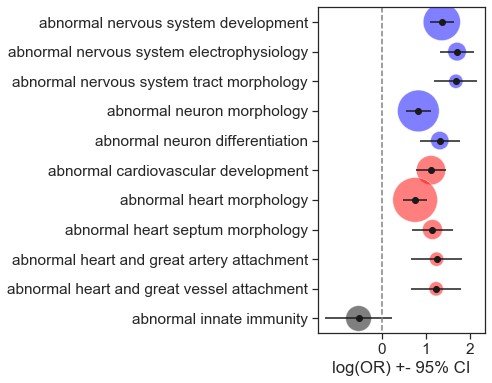

In [90]:
plt.figure(figsize=(3,6))

plt.errorbar(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),
            xerr=[np.subtract(root_KO_df.loc[terms_plot]['log_OR'],root_KO_df.loc[terms_plot]['log_OR_CI_lower']),
                   np.subtract(root_KO_df.loc[terms_plot]['log_OR_CI_upper'],root_KO_df.loc[terms_plot]['log_OR'])],color='k',fmt='o')

color_temp = root_KO_df.loc[terms_plot]['MPO_term_type'].map({'brain':'blue','heart':'red','neg_ctrl':'black'})
# plt.scatter(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),s=root_KO_df.loc[terms_plot]['num_genes_in_term'],alpha=.5,
#            c=color_temp.tolist())
sns.scatterplot(x=root_KO_df.loc[terms_plot]['log_OR'],
                y=np.arange(len(terms_plot)),size=root_KO_df.loc[terms_plot]['num_genes_in_term'],sizes=(200, 2000),
                alpha=.5,
               hue=color_temp.tolist(),palette={'blue':'blue','red':'red','black':'black'},legend=False)

plt.yticks(np.arange(len(terms_plot)),root_KO_df.loc[terms_plot]['MP_description'])
plt.xticks([0,1,2])
plt.xlabel('log(OR) +- 95% CI')

plt.plot([0,0],[-.5,len(terms_plot)-.5],'--',color='gray')
plt.ylim([-.5,len(terms_plot)-.5])

plt.gca().invert_yaxis()



# plt.savefig('ASD_CHD_brain_heart_MPO_root_enrichment_210813.png',dpi=300,bbox_inches='tight')



### 19. Compute enrichment of phenotype(s) in NetColoc subsystems.

In [45]:
MP_focal_top = root_KO_df.head(10).index.tolist() # record the top 10 overall
MP_full_results_df = validation.MPO_enrichment_full(hier_df,MPO,mgi_df,MP_focal_top,G_int)
MP_full_results_df.head()

abnormal nervous system development
Genes and Terms to keep: 191
abnormal nervous system electrophysiology
Genes and Terms to keep: 34
abnormal nervous system tract morphology
Genes and Terms to keep: 62
abnormal cardiovascular development
Genes and Terms to keep: 139
abnormal neuron morphology
Genes and Terms to keep: 262
abnormal neuron differentiation
Genes and Terms to keep: 16
abnormal heart morphology
Genes and Terms to keep: 369
abnormal heart septum morphology
Genes and Terms to keep: 41
decreased fetal cardiomyocyte proliferation
abnormal cardiac outflow tract development
Genes and Terms to keep: 16


,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal nervous system electrophysiology:-log(OR_p),abnormal nervous system electrophysiology:log_OR,abnormal nervous system electrophysiology:num_genes,abnormal nervous system electrophysiology:gene_ids,abnormal nervous system tract morphology:-log(OR_p),abnormal nervous system tract morphology:log_OR,...,abnormal heart septum morphology:num_genes,abnormal heart septum morphology:gene_ids,decreased fetal cardiomyocyte proliferation:-log(OR_p),decreased fetal cardiomyocyte proliferation:log_OR,decreased fetal cardiomyocyte proliferation:num_genes,decreased fetal cardiomyocyte proliferation:gene_ids,abnormal cardiac outflow tract development:-log(OR_p),abnormal cardiac outflow tract development:log_OR,abnormal cardiac outflow tract development:num_genes,abnormal cardiac outflow tract development:gene_ids
C350,22.738917,1.358205,73,ADNP ARID1A CACNA1A CACNA2D2 CCND1 CCND2 CHD7 ...,16.731282,1.701299,30,ANK3 CACNA1A CACNA2D2 CHD7 CHD8 ELAVL3 EPS8L2 ...,10.904244,1.675418,...,21,ARID1A CCND1 CHD7 HAND1 HDAC2 HOXA1 KDM6A KMT2...,5.819908,2.762957,4,CHD7 KMT2D SMARCD3 SPTBN1,5.310072,1.456095,11,ARID1A CHD7 HAND1 HOXA1 KMT2D PITX2 RARA RARB ...
C353,2.092072,0.970252,9,CACNA1A CACNA2D2 CNTN2 KCNA1 NRCAM SCN8A SPTAN...,34.739152,3.541826,21,ANK3 CACNA1A CACNA2D2 FGF14 GLDN KCNA1 KCNQ3 K...,2.073248,1.575458,...,2,SCN8A SPTBN1,2.413564,3.004830,1,SPTBN1,-0.000000,0.000000,0,
C386,3.111527,2.172537,4,ADNP NFIA SMARCA4 ZBTB14,-0.000000,0.000000,0,,1.432669,2.204263,...,3,SMARCA4 SMARCD3 ZBTB14,4.990873,4.780465,1,SMARCD3,1.828144,2.575753,1,SMARCA4
C356,1.862682,1.028190,7,ADNP KATNB1 NFIA SPAST SPG21 VPS26A ZBTB14,-0.000000,0.000000,0,,1.345495,1.460157,...,2,SMYD1 ZBTB14,-0.000000,0.000000,0,,-0.000000,0.000000,0,
C358,1.040115,0.819527,5,ADNP CHD8 KATNB1 NFIA ZBTB14,0.174659,0.434783,1,CHD8,0.426552,0.903564,...,3,SHOC2 SMYD1 ZBTB14,-0.000000,0.000000,0,,-0.000000,0.000000,0,


### 20. Annotate NetColoc systems map with mouse knockout data, seed genes, and enriched GO terms

In [102]:
# add the best gprofiler annotation
MP_full_results_df['gprofiler_name']=pd.Series(system_name_list,index=hier_df.index.tolist())
# don't annotate the root node
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]
MP_full_results_df['gprofiler_name'].loc[root_node]=d1_name+'-'+d2_name+' systems map'

# also add the frac_seeds/num_seeds data here
MP_full_results_df=MP_full_results_df.join(hier_df[['num_d1_seeds','num_d2_seeds','frac_d1_seeds','frac_d2_seeds','frac_no_seeds']],
                                          how='left')

MP_full_results_df.head()

/Users/brinrosenthal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal nervous system electrophysiology:-log(OR_p),abnormal nervous system electrophysiology:log_OR,abnormal nervous system electrophysiology:num_genes,abnormal nervous system electrophysiology:gene_ids,abnormal nervous system tract morphology:-log(OR_p),abnormal nervous system tract morphology:log_OR,...,abnormal cardiac outflow tract development:-log(OR_p),abnormal cardiac outflow tract development:log_OR,abnormal cardiac outflow tract development:num_genes,abnormal cardiac outflow tract development:gene_ids,gprofiler_name,num_d1_seeds,num_d2_seeds,frac_d1_seeds,frac_d2_seeds,frac_no_seeds
C350,22.738917,1.358205,73,ADNP ARID1A CACNA1A CACNA2D2 CCND1 CCND2 CHD7 ...,16.731282,1.701299,30,ANK3 CACNA1A CACNA2D2 CHD7 CHD8 ELAVL3 EPS8L2 ...,10.904244,1.675418,...,5.310072,1.456095,11,ARID1A CHD7 HAND1 HOXA1 KMT2D PITX2 RARA RARB ...,ASD-CHD systems map,27,18,0.081571,0.054381,0.864048
C353,2.092072,0.970252,9,CACNA1A CACNA2D2 CNTN2 KCNA1 NRCAM SCN8A SPTAN...,34.739152,3.541826,21,ANK3 CACNA1A CACNA2D2 FGF14 GLDN KCNA1 KCNQ3 K...,2.073248,1.575458,...,-0.000000,0.000000,0,,L1CAM interactions,5,3,0.092593,0.055556,0.851852
C386,3.111527,2.172537,4,ADNP NFIA SMARCA4 ZBTB14,-0.000000,0.000000,0,,1.432669,2.204263,...,1.828144,2.575753,1,SMARCA4,C386,1,0,0.100000,0.000000,0.900000
C356,1.862682,1.028190,7,ADNP KATNB1 NFIA SPAST SPG21 VPS26A ZBTB14,-0.000000,0.000000,0,,1.345495,1.460157,...,-0.000000,0.000000,0,,C356,5,3,0.125000,0.075000,0.800000
C358,1.040115,0.819527,5,ADNP CHD8 KATNB1 NFIA ZBTB14,0.174659,0.434783,1,CHD8,0.426552,0.903564,...,-0.000000,0.000000,0,,C358,3,1,0.088235,0.029412,0.882353


### 21. Export NetColoc systems map to NDEx, with default style. 

Default style maps fraction of seed genes from seed set 1 (red) and seed set 2 (blue) to node pie charts. Fraction of genes in each system which are in neither seed set, but which are implicated by the network are indicated with white. 

In [97]:
# Convert G_hier to nice cx network
node_id_to_node_name = nx.get_node_attributes(G_hier, 'name')
for node_id in list(G_hier.nodes):
    del G_hier.nodes[node_id]['name']

G_hier_cx = ndex2.create_nice_cx_from_networkx(G_hier)

for node_id, node in G_hier_cx.get_nodes():
    node['n'] = node_id_to_node_name[node_id]

G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map') 
for node_id, node in G_hier_cx.get_nodes():
    data = MP_full_results_df.loc[node['r']]
    for row, value in data.items():
        if (row.find('gene_ids')>-1) or (row=='gprofiler_name'):
            data_type = "string"
            value=str(value)
        else:
            data_type = "double"
            value = str(value) # nice cx can only accept strings as values...
            if value=='inf': # check if inf, set to -1 if so
                value='-1'
            
        G_hier_cx.set_node_attribute(node_id, row, value, type=data_type)

# some CDAPs properties were corrupted on networkx conversion. Fix them here
for node_id, node in G_hier_cx.get_nodes():
    for i in np.arange(len(G_hier_cx.nodeAttributes[node_id])):
        dict_temp = G_hier_cx.nodeAttributes[node_id][i]
        if dict_temp['n'] in ['CD_MemberList_Size','CD_MemberList_LogSize','HiDeF_persistence']:
            G_hier_cx.set_node_attribute(node_id, dict_temp['n'], dict_temp['v'], type='double',overwrite=True)
            
# this is required so we can easily make subgraphs from systems
G_hier_cx.set_network_attribute('__CD_OriginalNetwork',
                                       values='0', type='long')
            
          
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='36041bac-d2e3-11eb-b666-0ac135e8bacf')
G_hier_cx.apply_style_from_network(netcoloc_template)

In [98]:
#Upload to NDEx
G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map') 
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid_hier = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: sbrosenthal@health.ucsd.edu
NDEx password: ········
Generating CX


### 22. Apply another template style to NetColoc systems map for mouse knockout view, and export to NDEx. 

Select the property to be mapped to system node colors (should be one of the mouse knockout phenotypes we identified above). In this style, the log odds ratio is mapped to the system node color. Systems which are not significantly enriched for the phenotype are white (p<0.05).


In [99]:
# ------ modify this based on your project. Should be a system identified above -----
# set the property we should map to system node colors
mouse_KO_mapping_property = 'abnormal neuron morphology'

In [100]:
# apply a template style 
G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map_mouse_KO:'+mouse_KO_mapping_property) 
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='4958993c-df46-11eb-b666-0ac135e8bacf')
raw_cx_st = json.dumps(netcoloc_template.to_cx())

# replace the default template values with mouse_KO_mapping_property
updated_raw_cx = re.sub('COL=abnormal heart development:log_OR', 'COL='+mouse_KO_mapping_property+':log_OR', raw_cx_st)
updated_raw_cx = re.sub('COL=abnormal heart development:-log', 
                        'COL='+mouse_KO_mapping_property+':-log', updated_raw_cx)
updated_raw_cx=json.loads(updated_raw_cx)
netcoloc_template_updated = ndex2.create_nice_cx_from_raw_cx(updated_raw_cx)
G_hier_cx.apply_style_from_network(netcoloc_template_updated)

network_uuid_hier_mouse_KO = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX
Generating CX


### 23. Add genes associated with mouse knockout phenotypes to NetColoc subgraph, export to NDEx. 

In [103]:
# add fields to node_df for genes in each mouse_KO phenotype of interest
MP_genes_columns = [c for c in MP_full_results_df.columns.tolist() if c.find(':gene_ids')>-1]

# look up overlapping genes in the root node, add them to node_df
for MP in MP_genes_columns:
    focal_genes = MP_full_results_df.loc[root_node][MP].split(' ')
    node_df[MP]=0
    node_df[MP].loc[focal_genes]=1
node_df.head()

,d1_seeds,d2_seeds,z_d1,z_d2,z_both,d1_name,d2_name,sum_seeds,abnormal nervous system development:gene_ids,abnormal nervous system electrophysiology:gene_ids,abnormal nervous system tract morphology:gene_ids,abnormal cardiovascular development:gene_ids,abnormal neuron morphology:gene_ids,abnormal neuron differentiation:gene_ids,abnormal heart morphology:gene_ids,abnormal heart septum morphology:gene_ids,decreased fetal cardiomyocyte proliferation:gene_ids,abnormal cardiac outflow tract development:gene_ids
KDM5B,1,1,8.745623,8.198657,71.702356,ASD,CHD,2,0,0,0,0,0,0,0,0,0,0
CLUH,0,1,5.294906,13.015273,68.914648,ASD,CHD,1,0,0,0,0,0,0,0,0,0,0
KMT2C,1,1,8.819306,7.349744,64.819635,ASD,CHD,2,0,0,0,0,0,0,0,0,0,0
PTEN,1,1,6.944277,7.072284,49.111900,ASD,CHD,2,1,0,1,1,1,1,1,0,0,0
EIF3G,1,0,8.506393,5.452404,46.380288,ASD,CHD,1,0,0,0,0,0,0,0,0,0,0


In [104]:
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_overlap_cx.apply_template('ndexbio.org','834b6ad4-d2ea-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc = G_overlap_cx.upload_to(SERVER, USERNAME, PASSWORD)

350
1810
Generating CX


### Upload cosine-similarity transformed NetColoc subgraph to NDEx

In [105]:
#Annotate network
print(len(G_cosSim.nodes()))
print(len(G_cosSim.edges()))
G_cosSim_cx = ndex2.create_nice_cx_from_networkx(G_cosSim)
G_cosSim_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph_CosSim95') 
for node_id, node in G_cosSim_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_cosSim_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_cosSim_cx.apply_template('ndexbio.org','2cbed84b-e5c3-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc_CosSim = G_cosSim_cx.upload_to(SERVER, USERNAME, PASSWORD)

350
1721
Generating CX


### Add 4 networks from above to network set

In [110]:
# append the datestring to the network set to guarantee uniqueness
datestr = str(datetime.now())
networkSetURL=ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).create_networkset(d1_name+'-'+d2_name+' network set: '+datestr,'network set for '+d1_name+'-'+d2_name+' NetColoc subgraph and systems map')
networkSetURL

'http://public.ndexbio.org/v2/networkset/2d06b649-0777-11ec-b666-0ac135e8bacf'

In [111]:
# parse out UUID from URL strings
networkSetUUID = networkSetURL.split('/')[-1]
networkSetUUID

networkURLs = [network_uuid_NetColoc,network_uuid_NetColoc_CosSim,network_uuid_hier,network_uuid_hier_mouse_KO]
networkUUIDs = [n.split('/')[-1] for n in networkURLs]

ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).add_networks_to_networkset(networkSetUUID,
                                                                                              networkUUIDs)


'http://public.ndexbio.org/v2/networkset/2d06b649-0777-11ec-b666-0ac135e8bacf/members'